# RFM Modelling 

In this notebook, we attempt to first explore these questions by looking at the data in a 3 month period:

1. What is the spending profile of our customers with our business? i.e. how do customers interact with our business
2. Are there different types of customers? Do they fall into recognisable clusters?

3 months is chosen arbitrarily; since data is collected weekly 3 months gives ~12 date's data points.

Each metric is calculated as follows:

Recency: #Days since last purchase (end date - last purchase)  
Frequency: #Days with at least 1 purchase item (out of 3 month period)  
Monetary: Sum of value of all purchased item in 3 month period (confounded with frequency? Should we take largest receipt/average receipt?)

In [1]:
import pandas as pd

%matplotlib inline

data = pd.read_csv("../data/DSA3101_Hackathon_Data.csv")
data.head()

,Panel ID,Date,Category,Pack Size,Volume,Spend
0,Panel 101011101,2017-07-02,CSD,1,1.5,1.5
1,Panel 101011101,2017-07-02,Soy Milk,1,1.0,2.8
2,Panel 101011101,2017-07-02,Cooking Sauces,1,0.3,3.2
3,Panel 101011101,2017-07-02,Coconut Milk,2,0.4,5.3
4,Panel 101011101,2017-07-02,Chocolate,1,0.2,6.6


In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1318024 entries, 0 to 1318023
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   Panel ID   1318024 non-null  object 
 1   Date       1318024 non-null  object 
 2   Category   1318024 non-null  object 
 3   Pack Size  1318024 non-null  int64  
 4   Volume     1318024 non-null  float64
 5   Spend      1318024 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 60.3+ MB


In [3]:
data['Date'] = pd.to_datetime(data['Date'])
data.head()

,Panel ID,Date,Category,Pack Size,Volume,Spend
0,Panel 101011101,2017-07-02,CSD,1,1.5,1.5
1,Panel 101011101,2017-07-02,Soy Milk,1,1.0,2.8
2,Panel 101011101,2017-07-02,Cooking Sauces,1,0.3,3.2
3,Panel 101011101,2017-07-02,Coconut Milk,2,0.4,5.3
4,Panel 101011101,2017-07-02,Chocolate,1,0.2,6.6


In [4]:
demographics = pd.read_excel("../data/DSA3101_Hackathon_Panelists_Demographics.xlsx")
demographics.head()

,ID,BMI,Income,Ethnicity,Lifestage,Strata,#HH,location
0,Panel 101011101,Obese,Income 1500 - 1999,North Malay,Empty Nesters,Urban,1-3 Member HH,North
1,Panel 101016101,Healthy,Income 1500 - 1999,North Malay,Teens Aches,Urban,1-3 Member HH,North
2,Panel 101019101,Obese,Income < 1500,North Malay,Teens Aches,Urban,4 Member HH,North
3,Panel 101024101,Over Weight,Income 1500 - 1999,North Chinese,Nesting Families,Urban,1-3 Member HH,North
4,Panel 105009103,Over Weight,Income < 1500,North Malay,Empty Nesters,Rural,1-3 Member HH,North


In [5]:
demographics["Income"].value_counts()

Income >5000          1071
Income 2000 - 2999     824
Income 3000 - 3999     673
Income < 1500          580
Income 1500 - 1999     456
Income 4000 - 4999     422
Name: Income, dtype: int64

In [6]:
from datetime import timedelta

latest = data["Date"].max()
cutoff = latest - timedelta(weeks=12)

data_latest = data[data["Date"] > cutoff]
data_latest["Date"].value_counts()

2020-03-29    10495
2020-04-26    10093
2020-04-12     9088
2020-05-03     8788
2020-04-05     8597
2020-04-19     8526
2020-05-24     8521
2020-06-07     8384
2020-05-10     8363
2020-05-17     8128
2020-05-31     7949
2020-06-14     7646
Name: Date, dtype: int64

In [7]:
latest_agg = data_latest.groupby(["Panel ID", "Date"]).agg(
    {'Spend': sum}).reset_index().groupby("Panel ID").agg(
    {"Date": lambda x: (latest-x.max()).days,
     "Panel ID": len,
     "Spend": sum})

In [8]:
latest_agg.columns = ['Recency', 'Frequency', 'Monetary']

In [9]:
latest_agg

,Recency,Frequency,Monetary
Panel ID,,,
Panel 101011101,14,9,865.2
Panel 101016101,7,6,205.1
Panel 101019101,0,9,648.3
Panel 101024101,0,10,291.1
Panel 105009103,0,12,375.9
...,...,...,...
Panel 801899801,0,7,964.7
Panel 801900301,0,9,329.3
Panel 801900701,28,3,21.0


Looking at the distribution of recency values below, since most customers have recency = 0, it would not make sense to divide by quantiles. Also, 5 levels is too much for such a distribution. Thus we will score Recency as follows:

1. Most recent (0): 4
2. Within a week (7): 3
3. Within a month (14-28): 2
4. &gt; month: 1

In [10]:
latest_agg['Recency'].value_counts()

0     1428
7      295
14      69
21      48
28      46
56      25
35      15
42      12
49      11
63      10
70       9
77       4
Name: Recency, dtype: int64

In [11]:
latest_agg['Frequency'].value_counts()

12    469
11    265
10    212
9     199
8     171
7     162
6     139
5     105
4      97
3      62
2      51
1      40
Name: Frequency, dtype: int64

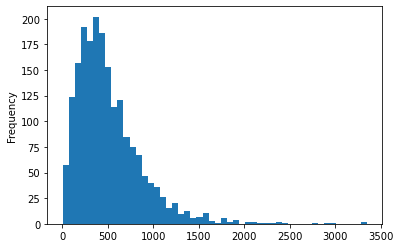

In [12]:
latest_agg['Monetary'].plot(kind='hist', bins=50)

Monetary has a more even distribution, so we can assign by quantiles. For consistency we also split into 4 scores

In [13]:
recency_score = pd.cut(latest_agg['Recency'], bins=[0, 6, 8, 28, 100], labels=[4,3,2,1], include_lowest=True)
freq_score = pd.cut(latest_agg['Frequency'], bins=[0,3,6,9,12], labels=[1,2,3,4])
monetary_score = pd.qcut(latest_agg['Monetary'], q=4, labels=[1,2,3,4])

In [14]:
rfm = pd.DataFrame(data={   
   "R": recency_score.astype('int'),
   "F": freq_score.astype('int'),
   "M": monetary_score.astype('int')
}).reset_index()
rfm

,Panel ID,R,F,M
0,Panel 101011101,2,3,4
1,Panel 101016101,3,2,1
2,Panel 101019101,4,3,3
3,Panel 101024101,4,4,2
4,Panel 105009103,4,4,2
...,...,...,...,...
1967,Panel 801899801,4,3,4
1968,Panel 801900301,4,3,2
1969,Panel 801900701,2,1,1
1970,Panel 801901201,4,3,2


In [15]:
rfm['RFM'] = rfm.R.map(str) + rfm.F.map(str) + rfm.M.map(str)
rfm

,Panel ID,R,F,M,RFM
0,Panel 101011101,2,3,4,234
1,Panel 101016101,3,2,1,321
2,Panel 101019101,4,3,3,433
3,Panel 101024101,4,4,2,442
4,Panel 105009103,4,4,2,442
...,...,...,...,...,...
1967,Panel 801899801,4,3,4,434
1968,Panel 801900301,4,3,2,432
1969,Panel 801900701,2,1,1,211
1970,Panel 801901201,4,3,2,432


In [16]:
rfm_counts = rfm.groupby(['R','F','M']).agg({'RFM':len}).reset_index()
rfm_counts

,R,F,M,RFM
0,1,1,1,53
1,1,1,2,6
2,1,1,3,2
3,1,2,1,19
4,1,2,2,4
5,1,2,3,1
6,1,3,3,1
7,2,1,1,29
8,2,1,2,5
9,2,1,3,2


In [17]:
rfm.to_csv("rfm_2020-03-29_to_2020-06-14.csv")

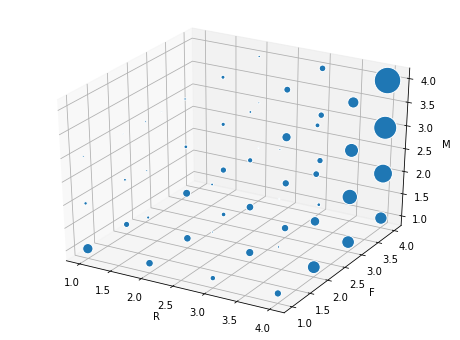

In [87]:
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

xs = rfm_counts['R']
ys = rfm_counts['F']
zs = rfm_counts['M']
s  = rfm_counts['RFM'] * 2
ax.scatter(xs, ys, zs, s=s, alpha=1, edgecolors='w')

ax.set_xlabel('R')
ax.set_ylabel('F')
ax.set_zlabel('M')

plt.show()